In [1]:
import sys
sys.path.append('/Users/admin/Desktop/tesi/Thesis/')
from scipy.io import loadmat
import import_ipynb
from handcrafted_descriptors.gabor_classification import utility as utility 

importing Jupyter notebook from /Users/admin/Desktop/tesi/Thesis/handcrafted_descriptors/gabor_classification/utility.ipynb


In [2]:
# load matlab file, where gabor descriptor is saved
def load_descriptor_from_matfile(ft_path,lab_path):
    feat = loadmat(ft_path)
    feat = feat['dsc']
    lab = loadmat(lab_path)
    lab = lab['lab']
    return feat, lab

In [3]:
species = ['Arthonia_radiata','Caloplaca_cerina','Candelariella_reflexa','Candelariella_xanthostigma','Chrysothrix_candelaris','Flavoparmelia_caperata','Gyalolechia_flavorubescens','Hyperphyscia_adglutinata'
        ,'Lecanora_argentata','Lecanora_chlarotera','Lecidella_elaeochroma','Melanelixia_glabratula'
        ,'Phaeophyscia_orbicularis','Physcia_biziana','Physconia_grisea','Ramalina_farinacea','Ramalina_fastigiata','Xanthomendoza_fallax','Xanthomendoza_fulva','flavoparmenia_soredians']


------------------
(8,3)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=100.0, gamma=0.01)
Accuracy score : 0.8307349665924276
start poly
Best estimator found by grid search :  SVC(degree=2, gamma=1, kernel='poly')
Accuracy score : 0.7639198218262806
start 1nn


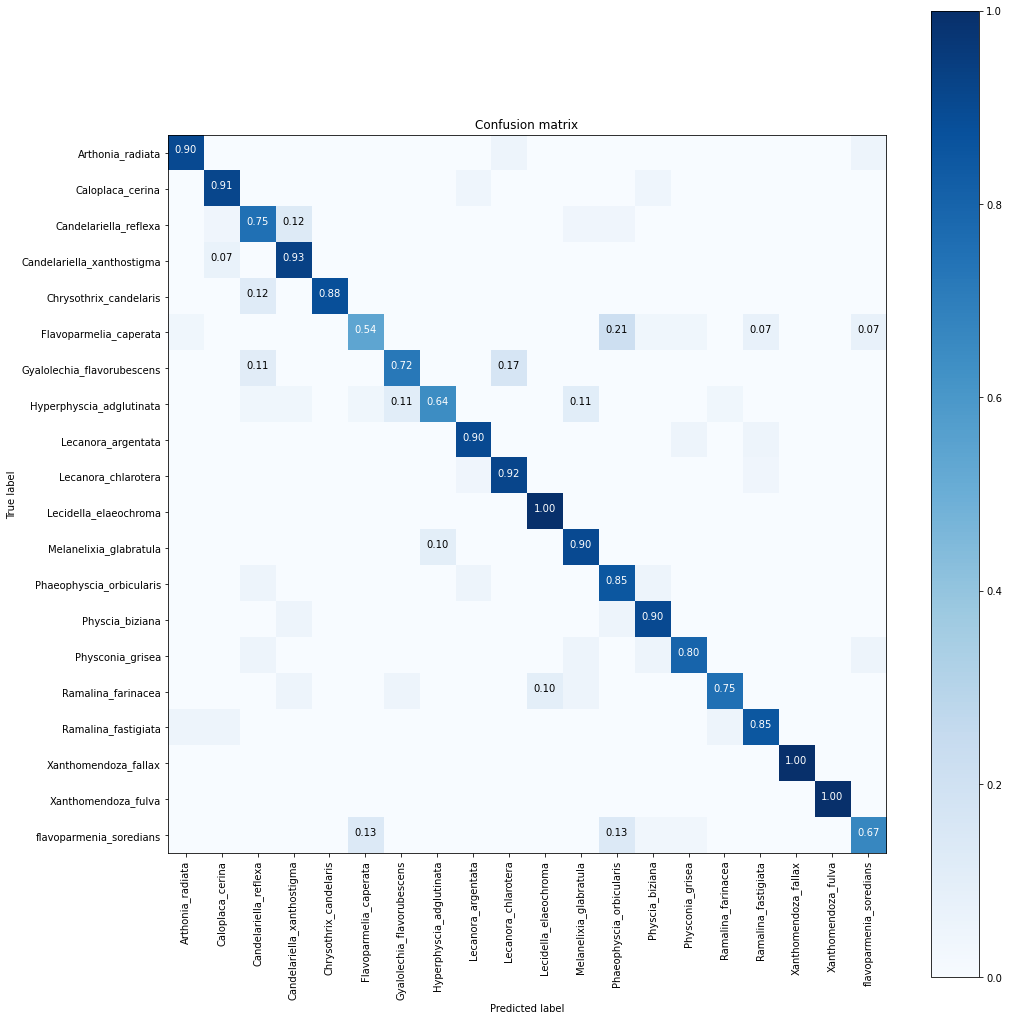

In [4]:
vector = ['1','2','3','4','5','6','7','8']


acc_radial = {}
acc_poly = {}
#acc_1nn = {}

for i,rot in enumerate(['8']):
    for j,scale in enumerate(['3']):
        print('------------------')
        print('(' + rot + ',' + scale + ')')
        print('-------------------')
        
        #create directories 
        director = 'results/results_gabor/confusion_matrix/'
        director_pra = 'results/results_gabor/pra/'
        name = 'cm_'+ rot + '_' + scale
        name_pra = 'pra_'+ rot + '_' + scale
        
        string_training = 'dsc/' + str(rot) + '_' + str(scale) + '_' + 'train_descriptors.mat'
        string_training_label = 'dsc/' + str(rot) + '_' + str(scale) + '_' + 'train_labels.mat'       
        string_testing = 'dsc/' + str(rot) + '_' + str(scale) + '_' + 'test_descriptors.mat'
        string_testing_label = 'dsc/' + str(rot) + '_' + str(scale) + '_' + 'test_labels.mat'
        
        training_feat,tr_lab = load_descriptor_from_matfile(string_training, string_training_label)
        tst_features, tst_lab = load_descriptor_from_matfile(string_testing,string_testing_label)
        tr_lab = tr_lab -1
        tst_lab = tst_lab -1 
        print('start rbf')
        svm ,score_rbf = utility.search_for_best_rbf(training_feat, tr_lab.reshape(-1), tst_features, tst_lab)
        pred = utility.create_and_save_confusion_matrix(svm, tst_features, tst_lab, species,director, name)
        utility.calculate_and_plot_precision_recall(tst_lab, pred, species, director_pra, name_pra)
        # claculate precision and recall 
        print('start poly')
        svm ,score_poly = utility.search_for_best_poly(training_feat, tr_lab.reshape(-1), tst_features, tst_lab)
        print('start 1nn')
        acc, prec, rec,clc  = utility.train_knn_model_and_calculate_accuracy(training_feat, tr_lab.reshape(-1), tst_features, tst_lab.reshape(-1))
        utility.plot_and_save_knn(acc,prec,rec,'knn_gabor')
        acc_radial['(' + str(rot) + ',' + str(scale) + ')'] = score_rbf
        #acc_poly['(' + str(rot) + ',' + str(scale) + ')'] = score_poly
        #acc_1nn['(' + str(rot) + ',' + str(scale) + ')'] = acc[0]
        

In [6]:
from sklearn.metrics import classification_report
y_pred = svm.predict(tst_features)
print(classification_report(tst_lab, y_pred, target_names=species))

                            precision    recall  f1-score   support

          Arthonia_radiata       0.85      0.85      0.85        20
          Caloplaca_cerina       0.83      0.83      0.83        23
     Candelariella_reflexa       0.57      0.67      0.62        24
Candelariella_xanthostigma       0.87      0.90      0.88        29
    Chrysothrix_candelaris       1.00      0.96      0.98        25
    Flavoparmelia_caperata       0.58      0.50      0.54        28
Gyalolechia_flavorubescens       0.71      0.56      0.63        18
  Hyperphyscia_adglutinata       0.62      0.29      0.39        28
        Lecanora_argentata       0.74      0.85      0.79        20
       Lecanora_chlarotera       0.81      0.92      0.86        24
     Lecidella_elaeochroma       0.79      0.94      0.86        16
    Melanelixia_glabratula       0.63      0.85      0.72        20
  Phaeophyscia_orbicularis       0.51      0.90      0.65        20
           Physcia_biziana       0.70      0.80